In [1]:
DATA_FOLDER = './data/g13/'
!mkdir -p {DATA_FOLDER}

### prepare

In [ ]:
g_2013 = pd.read_pickle('./data/g_2013.pkl')
g_2013.vcount(), g_2013.ecount()

In [ ]:
with open(f'{DATA_FOLDER}graph.tsv', 'w') as f:
    for e in tn(g_2013.es):
        for i in range(int(e['weight']) // 5 + 1):
            f.write(f"{g_2013.vs[e.source]['name']}\t{g_2013.vs[e.target]['name']}\n")
            f.write(f"{g_2013.vs[e.target]['name']}\t{g_2013.vs[e.source]['name']}\n")

In [ ]:
!tail {DATA_FOLDER}graph.tsv

In [ ]:
for f in ['dictionary.json', 'entity_count_all_*.txt', 'graph_partitioned/edges_*.h5']:
    !rm {DATA_FOLDER}{f}

In [ ]:
!torchbiggraph_import_from_tsv -l=0 -r=1 graph_config.py {DATA_FOLDER}graph.tsv

In [ ]:
!mkdir -p {DATA_FOLDER}logs

### train

In [ ]:
for TEMPLATE in ['checkpoint_version.txt', 'embeddings_all_*.h5', 'model.v*.h5']:
    !rm -f {DATA_FOLDER}model/{TEMPLATE}

In [ ]:
%time !torchbiggraph_train graph_config.py -p edge_paths={DATA_FOLDER}graph_partitioned > {DATA_FOLDER}logs/train.log

In [ ]:
!head {DATA_FOLDER}logs/train.log
print('-'*100)
!tail {DATA_FOLDER}logs/train.log

In [ ]:
!torchbiggraph_eval graph_config.py -p edge_paths={DATA_FOLDER}graph_partitioned > {DATA_FOLDER}logs/eval_train.log

In [ ]:
!head {DATA_FOLDER}logs/eval_train.log
print('-'*100)
!tail {DATA_FOLDER}logs/eval_train.log

### read

In [2]:
import os
import json
import h5py

In [3]:
path = f'{DATA_FOLDER}model'
files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.find('embeddings_all') != -1])
files = files[0:2] + files[8:] + files[2:8]
files

['./data/g13/model/embeddings_all_0.v20.h5']

In [4]:
with open(os.path.join(DATA_FOLDER, 'dictionary.json'), 'rt') as tf:
    dictionary = json.load(tf)
print(dictionary['relations'])
all_entities = dictionary['entities']['all']
len(all_entities)

['all_edges']


16229

In [5]:
embeddings=[]
for file in tn(files):
    with h5py.File(file, 'r') as hf:
        embedding = hf['embeddings'][...]
    embeddings.append(embedding)
embeddings = np.concatenate(embeddings, axis=0)
embeddings.shape

(16229, 100)

In [6]:
emb_df = pd.Series({i: e for i, e in tn(zip(all_entities, embeddings))}).to_frame(name='embeddings')
emb_df.shape

(16229, 1)

In [7]:
emb_df.sample(3)

,embeddings
10361,"[0.30139878, -0.10650614, -0.06491407, 0.02854..."
15696,"[0.025780974, 0.1477868, -0.3535937, 0.2071824..."
364,"[0.013964779, -0.04619126, -0.24827881, 0.0465..."


### save table and pairwise similarities

In [7]:
from sklearn.metrics import pairwise_distances

CONCEPTS_ID_NAME_DICT = {c['_id']: c['href_name'] for c in mc['sw']['concepts'].find()}
len(CONCEPTS_ID_NAME_DICT)

19446

In [8]:
emb_sim_2013 = pairwise_distances(embeddings, metric='cosine')
# emb_sim_2013 = pd.DataFrame(emb_sim_2013, index=emb_df.index.map(int).map(CONCEPTS_ID_NAME_DICT),
#                             columns=emb_df.index.map(int).map(CONCEPTS_ID_NAME_DICT))
emb_sim_2013 = pd.DataFrame(emb_sim_2013, index=emb_df.index.map(int),
                            columns=emb_df.index.map(int))
sorted_names = emb_sim_2013.columns[~emb_sim_2013.index.isna()].sort_values()
emb_sim_2013 = emb_sim_2013.loc[sorted_names, sorted_names]
emb_sim_2013 = emb_sim_2013.applymap(lambda d: 1 - d if d else d)
emb_sim_2013.to_pickle('./data/emb_sim_2013_df.pkl')
emb_sim_2013.shape

(16229, 16229)

In [ ]:
emb_sim_2013 = pd.read_pickle('./data/emb_sim_2013_df.pkl')
emb_sim_2013.shape

In [9]:
emb_sim_2013_s = emb_sim_2013.where(np.triu(np.ones(emb_sim_2013.shape), 1).astype(np.bool)).stack()
emb_sim_2013_s.to_pickle('./data/emb_sim_2013_s.pkl')
emb_sim_2013_s.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

count    1.316821e+08
mean     1.553991e-01
std      1.903968e-01
min     -6.008327e-01
1%      -2.349560e-01
5%      -1.380574e-01
10%     -8.210671e-02
25%      1.920581e-02
50%      1.441639e-01
75%      2.799927e-01
90%      4.100304e-01
95%      4.898050e-01
99%      6.316300e-01
max      9.959324e-01
dtype: float64

### insights

In [15]:
emb_sim_2013.index = emb_sim_2013.index.map(CONCEPTS_ID_NAME_DICT)
emb_sim_2013.columns = emb_sim_2013.columns.map(CONCEPTS_ID_NAME_DICT)
sorted_names = emb_sim_2013.columns[~emb_sim_2013.index.isna()].sort_values()
emb_sim_2013 = emb_sim_2013.loc[sorted_names, sorted_names]
emb_sim_2013

,%27t_Hooft-Polyakov_monopole,%27t_Hooft_limit,%27t_Hooft_operator,%27t_Hooft_symbol,0-1_loss_function,1-Butyl-3-methylimidazolium_hexafluorophosphate,1-D_radiative_transfer,1-Deoxy-D-xylulose_5-phosphate,1RXS,1_N_expansion,...,white-dwarf_cooling,white_hole_horizon,wide-field_survey,wide-scale_modelling,wide-scale_transdisciplinary_modelling_for_environment,worldsheet_metric,xspec,young_eruptive_star,zCOSMOS,zakharov-shabat_system
%27t_Hooft-Polyakov_monopole,0.000000,0.436079,0.590261,0.465181,-0.020133,0.132698,0.171027,0.056725,-0.014830,0.324308,...,0.278707,0.348928,-0.031440,0.041512,-0.051020,0.517675,-0.053285,0.045967,-0.011847,0.158213
%27t_Hooft_limit,0.436079,0.000000,0.707729,0.600536,0.115844,0.178881,-0.033439,0.194197,-0.036294,0.511971,...,0.150105,0.347617,-0.028174,-0.017337,-0.014465,0.649953,-0.108940,-0.015190,-0.028065,0.233112
%27t_Hooft_operator,0.590261,0.707729,0.000000,0.634449,0.184231,0.337456,0.132295,0.389841,-0.030623,0.399923,...,0.134277,0.290982,-0.016008,-0.103405,0.102905,0.553999,-0.093243,0.171159,-0.052268,0.284712
%27t_Hooft_symbol,0.465181,0.600536,0.634449,0.000000,0.173640,0.403413,0.113113,0.244778,0.003402,0.301096,...,0.317800,0.259478,-0.113991,-0.226140,0.036519,0.573470,-0.001737,0.117054,-0.007131,0.473673
0-1_loss_function,-0.020133,0.115844,0.184231,0.173640,0.000000,0.317764,0.171412,0.530766,-0.100171,0.028274,...,0.009378,0.075564,0.080606,0.312879,0.615554,0.034492,0.143559,0.271918,0.143267,0.285012
1-Butyl-3-methylimidazolium_hexafluorophosphate,0.132698,0.178881,0.337456,0.403413,0.317764,0.000000,0.254358,0.672176,-0.026978,0.012894,...,0.234869,0.034316,-0.029727,0.035892,0.350539,0.068383,0.063747,0.295843,0.086357,0.346836
1-D_radiative_transfer,0.171027,-0.033439,0.132295,0.113113,0.171412,0.254358,0.000000,0.314139,0.401427,0.097884,...,0.200232,0.270235,0.309891,0.197339,0.168638,0.136356,0.542103,0.522485,0.463692,0.067480
1-Deoxy-D-xylulose_5-phosphate,0.056725,0.194197,0.389841,0.244778,0.530766,0.672176,0.314139,0.000000,0.029675,0.086928,...,0.124152,-0.011681,0.121484,0.155351,0.446198,0.030800,0.115746,0.424563,0.112603,0.232872
1RXS,-0.014830,-0.036294,-0.030623,0.003402,-0.100171,-0.026978,0.401427,0.029675,0.000000,0.163874,...,0.269435,-0.009224,0.419364,0.151596,-0.086392,0.174679,0.675173,0.367210,0.420961,-0.061642
1_N_expansion,0.324308,0.511971,0.399923,0.301096,0.028274,0.012894,0.097884,0.086928,0.163874,0.000000,...,0.023241,0.121774,0.090702,0.103115,-0.138406,0.360103,0.074204,-0.011076,0.122499,0.165112


In [23]:
emb_sim_2013.mean().sort_values()

Quadrants                                 0.056468
Sketch                                    0.056596
Lithium_1                                 0.056759
Classification_4                          0.057968
Conjunction                               0.058288
Completeness                              0.060227
Theory_1                                  0.060256
Subgroup                                  0.060285
Field                                     0.060372
Newton                                    0.060765
Embedding                                 0.060814
Pinch                                     0.060900
Orbits                                    0.061441
Object_1                                  0.061714
Rank_1                                    0.062098
G2_4                                      0.062475
Andromeda_II                              0.062481
Bumping                                   0.062815
Units                                     0.063146
Primary_2                      

In [26]:
emb_sim_2013['Networks'].sort_values()

Wiener-Ikehara_theorem                        -0.400061
ESS_Bilbao                                    -0.382587
Ax-Kochen_theorem                             -0.377938
Finite_strain_theory                          -0.377108
Shape_from_motion                             -0.375900
2D_to_3D_conversion                           -0.368321
Dixon%27s_identity                            -0.353237
L_b%27s_theorem                               -0.352605
Multipactor_effect                            -0.352571
Orthogonal_symmetric_Lie_algebra              -0.351079
Vortex_lift                                   -0.344402
q-deformed_boson_algebra                      -0.344246
Higher-dimensional_gamma_matrices             -0.343415
Saros_cycle                                   -0.343379
Mattig_formula                                -0.343133
Singleton_field                               -0.340993
Absolute_parallelism                          -0.340024
Cambridge_Low_Frequency_Synthesis_Telescope   -0

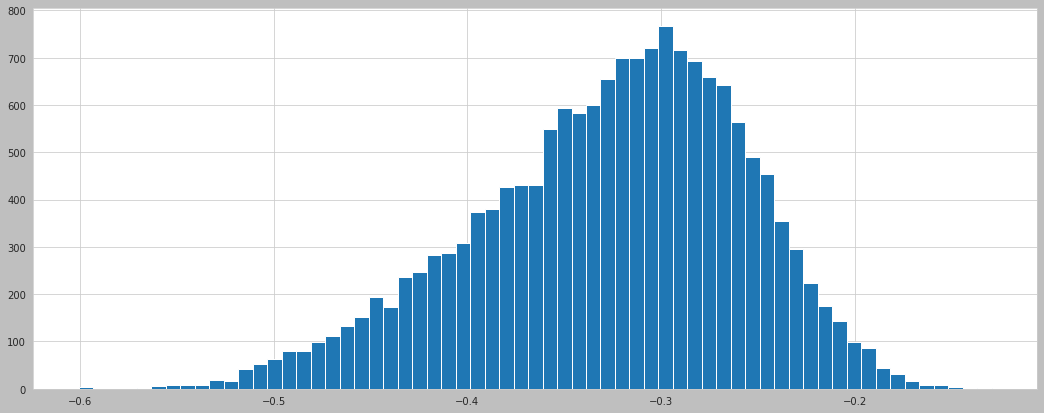

In [28]:
emb_sim_2013.min().hist(bins='auto');

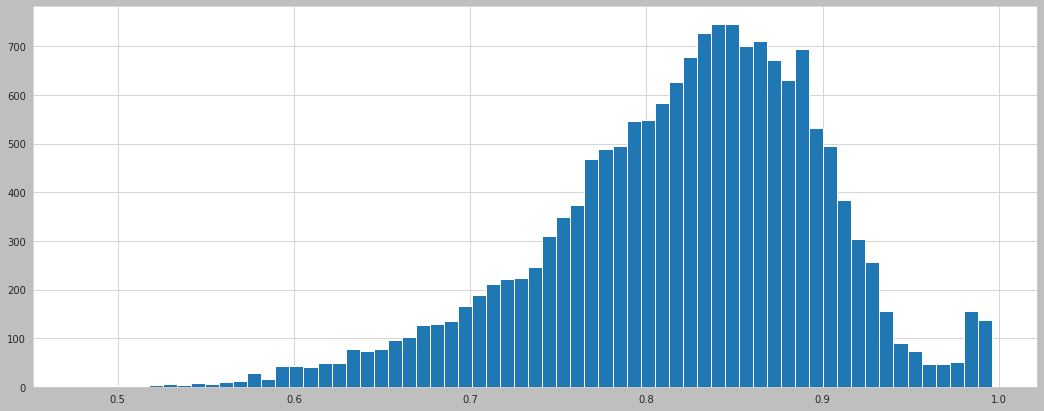

In [29]:
emb_sim_2013.max().hist(bins='auto');

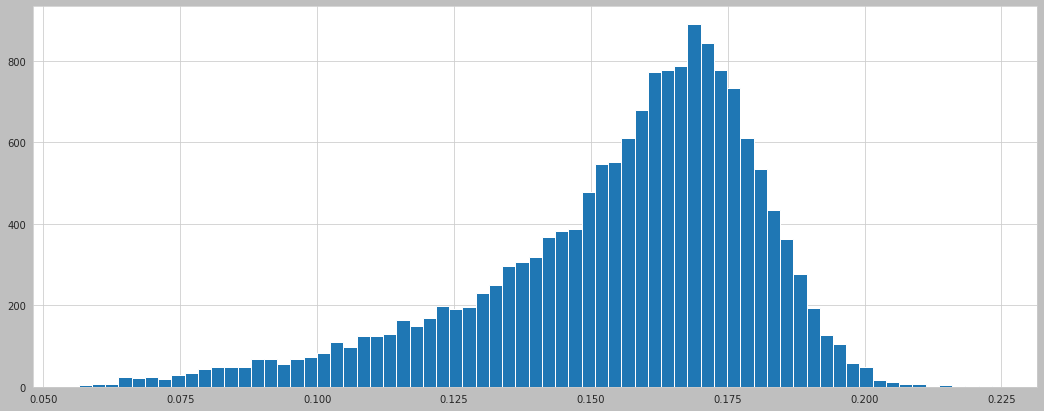

In [30]:
emb_sim_2013.mean().hist(bins='auto');

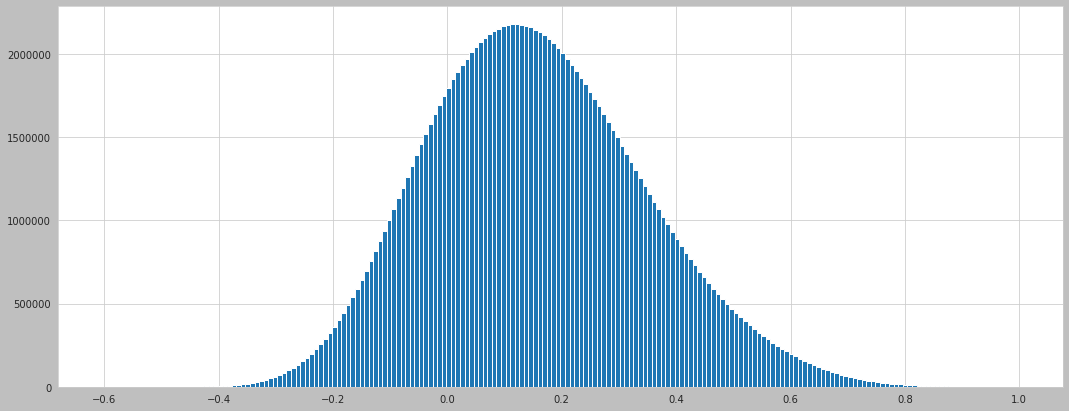

In [22]:
emb_sim_2013_s.hist(bins=200);